In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ttest_ind
from numpy import median
import pickle


In [2]:
# Make dictionaries for converting between sequence IDs

# Need list of proteins for each family
enzyme_order_df = pd.read_excel("data/initial_enzymes_1.xlsx")
sp_df = pd.read_excel("data/sp_prot_translations.xls")

# Map true protein ids
enzyme_order_df['prot_seq_trunc'] = enzyme_order_df['Protein-met-sigp'].str[:80]
sp_df['prot_seq_trunc'] = sp_df['prot_seq'].str[1:81]
merge_df = enzyme_order_df.merge(sp_df, how='inner', on='prot_seq_trunc')

# Get shuffled enzyme ID list back out
enzIDkeydf = merge_df[['enzyme_id','enzyme_type','seqID', 'new_id']]

seq2enzyme = pd.Series(enzIDkeydf.enzyme_id.values, index= enzIDkeydf.seqID).to_dict()
seq2family = pd.Series(enzIDkeydf.enzyme_type.values, index= enzIDkeydf.seqID).to_dict()
seq2newid = pd.Series(enzIDkeydf.new_id.values, index= enzIDkeydf.seqID).to_dict()
newid2seq = pd.Series(enzIDkeydf.seqID.values, index= enzIDkeydf.new_id).to_dict()

In [3]:
# Read in preprocessed data
df = pd.read_csv('data/preprocessed.csv')
df['run_index'] = [i for i in range(len(df))]
df = df.drop(columns=['Unnamed: 0'])

In [4]:
# Make data tidy
tidy_df = df.melt(id_vars=['correct', 'protein_id', 'sp_id', 'run_label', 'true_prot_id', 'prot_correct', 'sp_correct', 'family', 'run_id', 'run_index'], 
                  var_name='assay', value_name='assay_value')
tidy_df.rename(columns={'true_prot_id':'seqID'}, inplace=True)
tidy_df = tidy_df.sort_values(by = 'run_id', ascending = True).dropna()

# Rescreen Column remapping
remap_dict = {'amylase_2_10x': 'amylase_10x',
              'amylase_1_10x': 'amylase_10x',
              'positive_amy_10x': 'amylase_10x',
              'positive_xyl_50x': 'xylanase_50x',
              'xylanase_1_50x': 'xylanase_50x',
    
}
tidy_df['family'].replace(remap_dict, inplace=True)

In [5]:
# Create new 'correct' column based on results from pairwise alignments, which found more SPs
def combine_cols(row):
    if row["prot_correct"] == True and row["sp_correct"] == True:
        return True
    else:
        return False

tidy_df['old_correct'] = tidy_df['correct'].values
tidy_df['correct'] = tidy_df.apply(lambda x: combine_cols(x), axis=1)

In [6]:
rescreen_fams = [fam for fam in list(set(tidy_df['family'].values)) if fam[-2:] == '0x']
all_fams = [fam for fam in list(set(tidy_df['family'].values))]
reg_fams = [fam for fam in all_fams if fam not in rescreen_fams]
print(all_fams)
print(rescreen_fams)
print(reg_fams)

['xylanase', 'positive', 'xylanase_50x', 'amylase_10x', 'protease', 'lipase', 'amylase', 'negative']
['xylanase_50x', 'amylase_10x']
['xylanase', 'positive', 'protease', 'lipase', 'amylase', 'negative']


In [7]:
# Remove rescreens
tidy_df = tidy_df[tidy_df['run_id'] != '26_15-2']
tidy_df = tidy_df[tidy_df['family'].isin(reg_fams)]
set(tidy_df['family'].values)

{'amylase', 'lipase', 'negative', 'positive', 'protease', 'xylanase'}

In [8]:
# Need list of proteins for each family
enzyme_order_df = pd.read_excel("data/initial_enzymes_1.xlsx")
sp_df = pd.read_excel("data/sp_prot_translations.xls")

# Map true protein ids
enzyme_order_df['prot_seq_trunc'] = enzyme_order_df['Protein-met-sigp'].str[:80]
sp_df['prot_seq_trunc'] = sp_df['prot_seq'].str[1:81]
merge_df = enzyme_order_df.merge(sp_df, how='inner', on='prot_seq_trunc')

merge_df[['enzyme_id','enzyme_type','seqID', 'new_id']]

# Get shuffled enzyme ID list back out
enzIDkeydf = merge_df[['enzyme_id','enzyme_type','seqID', 'new_id']]

In [9]:
tidy_df.head(2)

,correct,protein_id,sp_id,run_label,seqID,prot_correct,sp_correct,family,run_id,run_index,assay,assay_value,old_correct
5158,True,Arnold_038,sps10-1,xylanase_1,seq10,True,True,xylanase,10_10-1,522,assay_5_value,0.760,True
1681,True,Arnold_038,sps10-1,xylanase_1,seq10,True,True,xylanase,10_10-1,522,assay_2_value,0.818,True


In [10]:
prot_fams = ['amylase', 'lipase', 'protease', 'xylanase']

## Visualize negative controls

These constructs either did not have a SP or enzymatic sequence post Golden Gate Assembly.

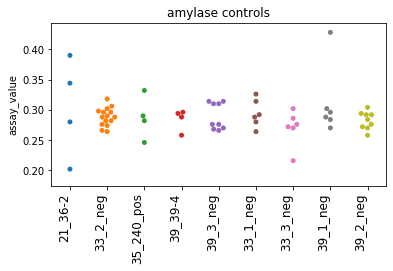

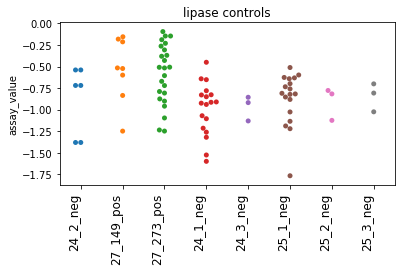

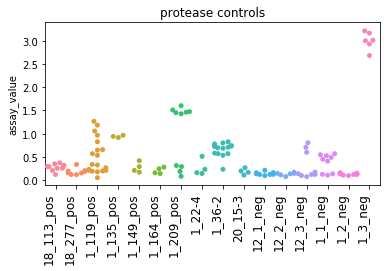

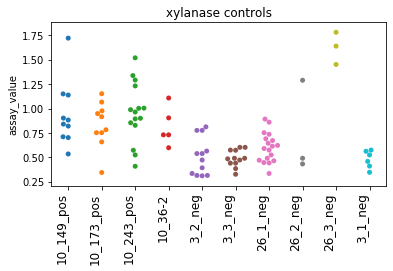

In [11]:
for fam in prot_fams:

    enzkey = enzIDkeydf[enzIDkeydf['enzyme_type'] == fam]
    fam_seqIDs = list(set(enzkey['seqID'].values))         # Shuffled seqIDs 

    # Entries to search for within df
    search_fams = [fam, 'positive', 'negative']   # also search positive/negative libraries

    # Pick points that are in the correct family and are the correct seqIDs
    fam_df = tidy_df[(tidy_df['family'].isin(search_fams)) & tidy_df['seqID'].isin(fam_seqIDs)].copy()

    # Take incorrect constructs as negative controls
    false_construct_df = fam_df[fam_df['correct'] == False]
    random_construct_df = fam_df[fam_df['family'] == 'negative']
    neg_df = pd.concat([false_construct_df, random_construct_df])
    # neg_df = neg_df.assign(run_id='neg_controls')
    neg_values = neg_df['assay_value'].values
    neg_avg = np.average(neg_values)

    try:
        fig, ax = pyplot.subplots(figsize=(6,3))
        chart = sns.swarmplot(ax=ax, x="run_id", y="assay_value", data=neg_df)
        chart.set_title(fam + " controls")
        chart.set_xticklabels(
                chart.get_xticklabels(), 
                rotation=90, 
                horizontalalignment='right',
                fontweight='light',
                fontsize='large'
            )
        chart.xaxis.label.set_visible(False)
    except ValueError:
        print(f"{fam} cannot be plotted")


In [12]:
tidy_df[tidy_df['seqID']=='seq19']

,correct,protein_id,sp_id,run_label,seqID,prot_correct,sp_correct,family,run_id,run_index,assay,assay_value,old_correct
3570,True,Arnold_002,sps12-1,amylase_1,seq19,True,True,amylase,19_12-1,93,assay_4_value,0.274,True
1204,True,Arnold_002,sps12-1,amylase_1,seq19,True,True,amylase,19_12-1,45,assay_2_value,0.304,False (-SP/-Protein)
45,True,Arnold_002,sps12-1,amylase_1,seq19,True,True,amylase,19_12-1,45,assay_1_value,0.272,False (-SP/-Protein)
1252,True,Arnold_002,sps12-1,amylase_1,seq19,True,True,amylase,19_12-1,93,assay_2_value,0.366,True
3522,True,Arnold_002,sps12-1,amylase_1,seq19,True,True,amylase,19_12-1,45,assay_4_value,0.302,False (-SP/-Protein)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,True,Arnold_002,sps3-4,amylase_1,seq19,True,True,amylase,19_3-4,59,assay_3_value,0.254,True
71,True,Arnold_002,sps3-4,amylase_1,seq19,True,True,amylase,19_3-4,71,assay_1_value,0.296,True
3536,True,Arnold_002,sps3-4,amylase_1,seq19,True,True,amylase,19_3-4,59,assay_4_value,0.334,True
1218,True,Arnold_002,sps3-4,amylase_1,seq19,True,True,amylase,19_3-4,59,assay_2_value,0.388,True


## Now looking at all variants

#### Get proteins that have some level of function (by seqID)
Defined as having a mean activity higher than that of incorrect constructs, and also have a p-value < 0.01 as compared to incorrect constructs. This does include separate into individual runs.

In [13]:
### Get proteins that have some level of function (by seqID)

p_cutoff = 0.05
effect_size = 2

alive_proteins = set()    #seqIDs that have some function on some construct.
significant_count, total_count = 0,0

for fam in prot_fams:

    enzkey = enzIDkeydf[enzIDkeydf['enzyme_type'] == fam]
    fam_seqIDs = list(set(enzkey['seqID'].values))         # Shuffled seqIDs 

    # Entries to search for within df
    search_fams = [fam, 'positive', 'negative']   # also search positive/negative libraries

    # Pick points that are in the correct family and are the correct seqIDs
    fam_df = tidy_df[(tidy_df['family'].isin(search_fams)) & tidy_df['seqID'].isin(fam_seqIDs)].copy()

    # Take incorrect constructs as negative controls
    false_construct_df = fam_df[fam_df['correct'] == False]
    neg_values = false_construct_df['assay_value'].values
    neg_avg = np.average(neg_values)
    max_diff = np.max(neg_values) - neg_avg
    cutoff = neg_avg + effect_size * max_diff

    for run_id in set(fam_df['run_id'].values):
        _df = fam_df[fam_df['run_id'] == run_id]
        curr_values = _df['assay_value'].values
        curr_prot = _df.iloc[0]['seqID']
        p = ttest_ind(curr_values, neg_values, equal_var=False).pvalue
        if np.average(curr_values) > cutoff and p < p_cutoff:
            if curr_prot not in alive_proteins:
                print(curr_prot, p, neg_avg, np.average(curr_values))
            alive_proteins.add(curr_prot)
            
alive_proteins = list(alive_proteins)
alive_proteins.sort()
print(len(alive_proteins), alive_proteins)

seq5 0.02213569075998892 0.2926666666666667 0.6295000000000001
seq39 0.016048244946511286 0.2926666666666667 0.74925
seq19 8.177888638914069e-08 0.2926666666666667 1.5095
seq33 0.005704657557229392 0.2926666666666667 1.6660000000000001
seq21 0.0004642699558081244 0.2926666666666667 2.8729999999999998
seq25 3.227811232585658e-14 -0.5974028571428572 0.9705975
seq1 6.4652823162431755e-31 0.5030645569620253 5.011455
seq36 0.0009564079071764945 0.5030645569620253 3.1602
seq26 0.004540098604099237 0.8542608695652172 2.8004000000000007
seq3 0.004510971302027636 0.8542608695652172 2.938
10 ['seq1', 'seq19', 'seq21', 'seq25', 'seq26', 'seq3', 'seq33', 'seq36', 'seq39', 'seq5']


In [14]:
# Update with new plot_ids

seq2newid2 = {k[3:]:v for k,v in seq2newid.items()}
seq2newid.update({
    '003':'AprE', '021':'LipB', '066':'YbdG', '093':'YkvV', '144':'YvcE', '193':'YcnJ'
})
seq2newid2.update({
    '003':'AprE', '021':'LipB', '066':'YbdG', '093':'YkvV', '144':'YvcE', '193':'YcnJ'
})

pickle.dump(seq2newid2, open('data/final_plot_ids_2.p','wb'))

seq2newid2 = pickle.load(open("data/final_plot_ids_2.p", "rb"))

sp_plot_id = dict()
for i in range(41):
    for j in range(4):
        key = 'sps' + str(i+1) + '-' + str(j+1)
        value = i*4 + j + 1
        sp_plot_id.update({key:f"Gen_{value:03d}"})
sp_plot_id

with open('data/final_sp_plot_dict.p','wb') as f:
    pickle.dump(sp_plot_id, f)
    
with open('data/final_sp_plot_dict.p','rb') as f:
    sp_plot_id = pickle.load(f)

def get_new_id(row, include_prot=False):
    if row['run_id'] == 'false_construct':
        return 'incorrect construct'
    
    else:
        old_id = row['run_id'].split('_')

        if len(old_id) == 3: # then it's a control
            prot, sp, _ = old_id

            if old_id[-1] == 'neg':
                new_id = 'random_' + sp
            elif old_id[-1] == 'pos':
                try:
                    new_id = seq2newid2[sp]
                except KeyError:
                    new_id = 'incorrect construct pos'
    #                 print(old_id)
            else:
                raise ImplementationError

        elif len(old_id) == 2:
#             prot, sp = old_id
#             sp_ref, sp_num = sp.split('-')
#             new_id = seq2newid2[sp_ref] + '-' + sp_num
            new_id = sp_plot_id[row['sp_id']]
            
        else:
            raise ImplementationError

        if include_prot:
            new_id = seq2newid2[prot] + '_' + new_id

        return new_id
    
tidy_df['plot_id'] = df.apply(lambda row: get_new_id(row), axis=1)
tidy_df[(tidy_df['plot_id'] == 'incorrect_construct_pos') & (tidy_df['correct']==True)]

,correct,protein_id,sp_id,run_label,seqID,prot_correct,sp_correct,family,run_id,run_index,assay,assay_value,old_correct,plot_id


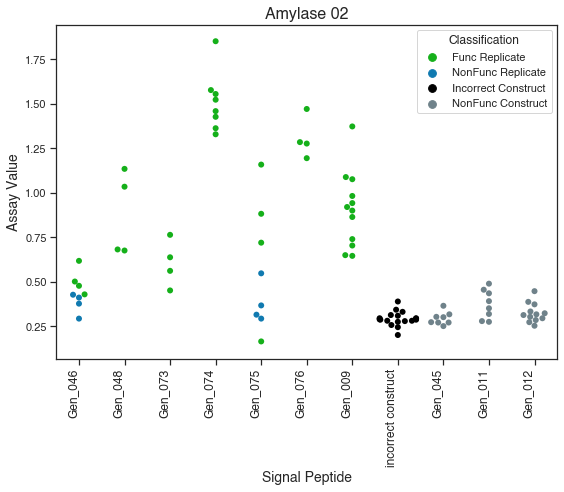

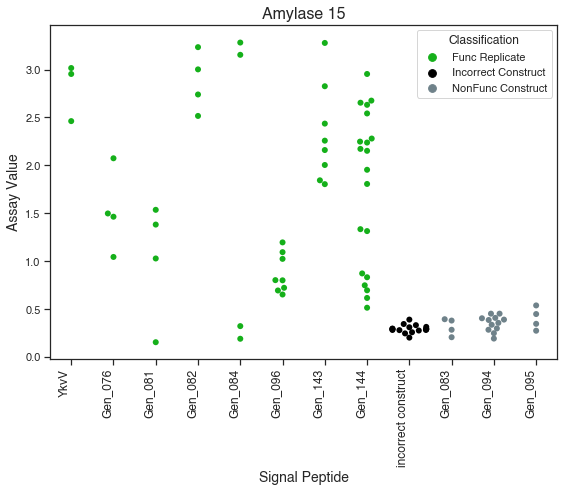

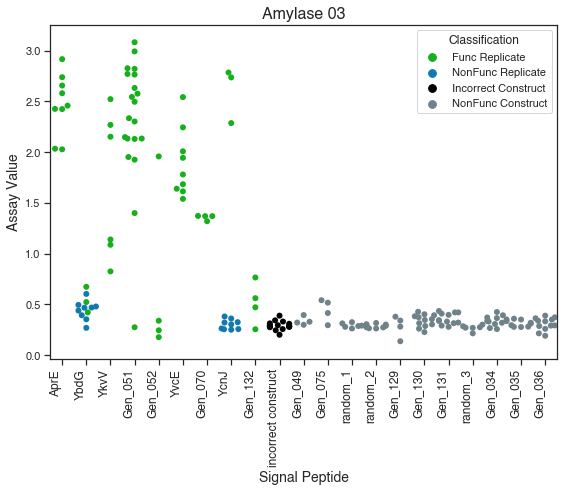

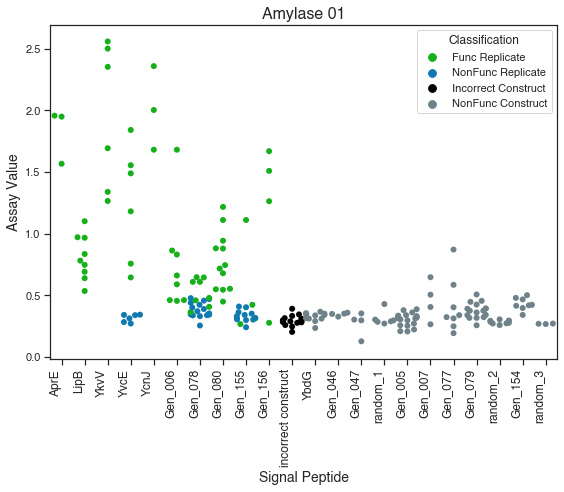

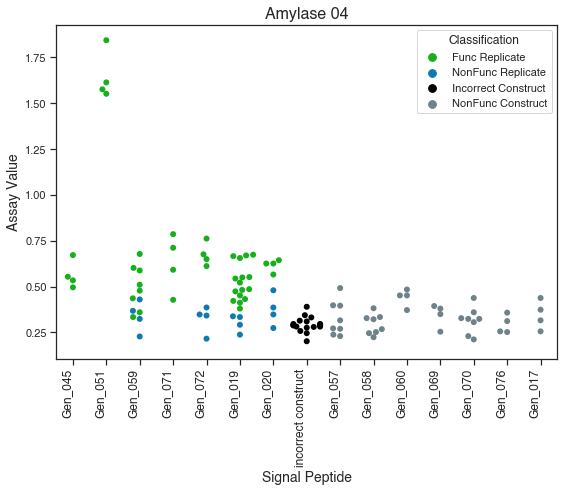

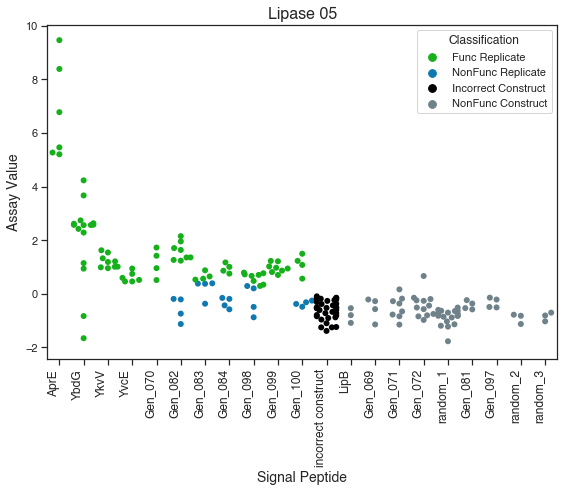

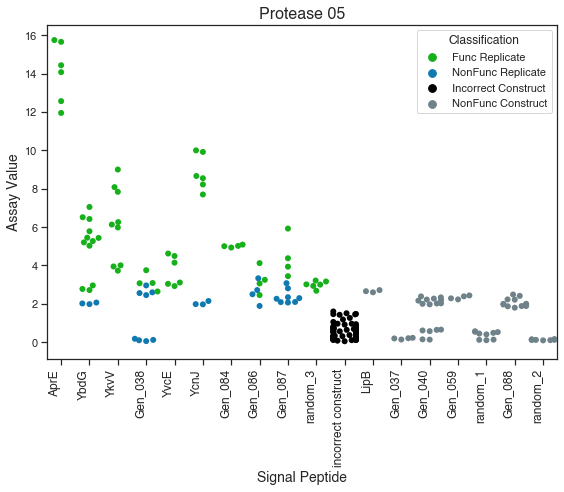

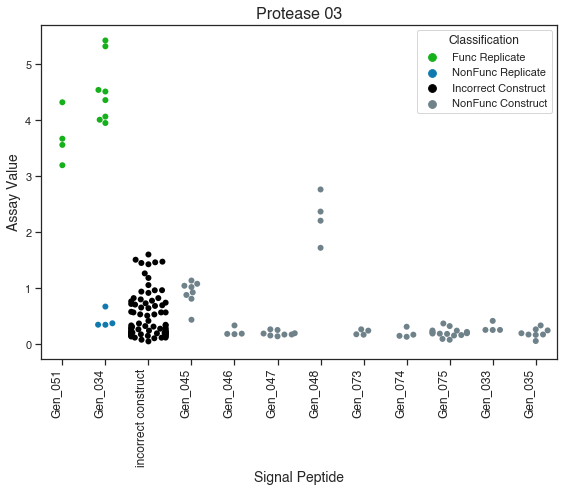

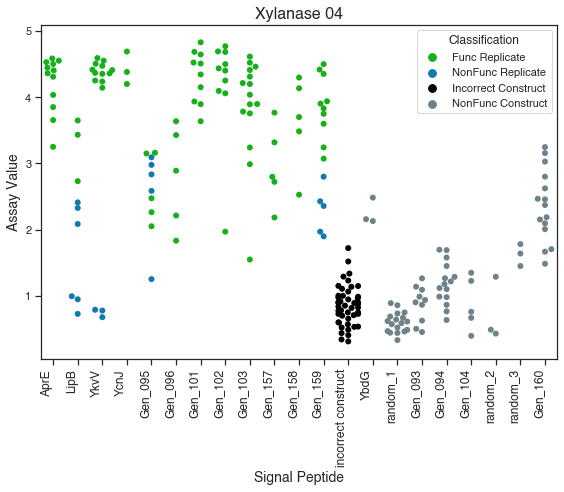

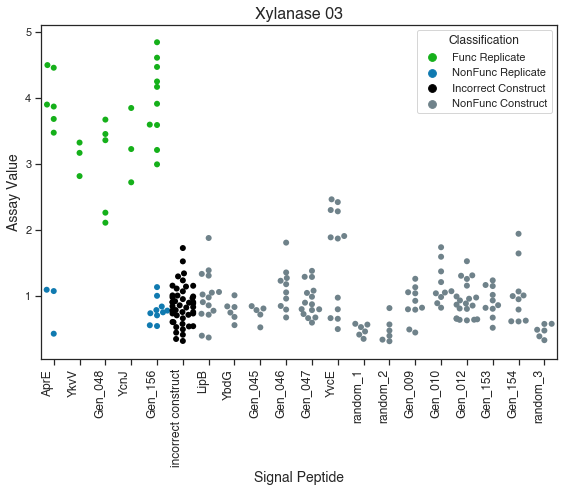

In [15]:
p_cutoff = 0.05
effect_size = 2.0
significant_count, total_count = 0,0

all_func_df = pd.DataFrame()
# all_nonfunc_df = pd.DataFrame()

all_func_constructs = []
all_nonfunc_constructs = []

run_ix_classification = dict()

for fam in prot_fams:

    enzkey = enzIDkeydf[enzIDkeydf['enzyme_type'] == fam]
    
    # Union with functional prots!!!
    fam_seqIDs = list(set(enzkey['seqID'].values).intersection(set(alive_proteins)))
    # Entries to search for within df
    search_fams = [fam, 'positive', 'negative']   # also search positive/negative libraries

    # Pick points that are in the correct family and are the correct seqIDs
    fam_seqIDs.sort()
#     print(set(enzkey['seqID'].values))
#     print(fam_seqIDs)
    fam_df = tidy_df[(tidy_df['family'].isin(search_fams)) & tidy_df['seqID'].isin(fam_seqIDs)]   # .copy()
    fam_df = fam_df[fam_df['correct'] == True]
    fam_run_ids = list(set(fam_df['run_id'].values))

    # Take incorrect constructs as negative controls, also get cutoff for p-value
    all_in_family_df = tidy_df[(tidy_df['family'].isin(search_fams)) & 
                                 (tidy_df['seqID'].isin(list(set(enzkey['seqID'].values))))].copy()
    false_construct_df = all_in_family_df[all_in_family_df['correct']==False].copy()
    false_construct_df['run_id'] = 'false_construct'
    neg_values = false_construct_df['assay_value'].values
    neg_avg = np.average(neg_values)
    max_diff = np.max(neg_values) - neg_avg
    cutoff = neg_avg + (effect_size*max_diff)

    func_constructs = set()
#     nonfunc_constructs = set() 
    
    for run_ix in set(fam_df['run_index'].values):
        _df = fam_df[fam_df['run_index'] == run_ix]
        
        # Classify as functioning or not
        curr_values = _df['assay_value'].values
        p = ttest_ind(curr_values, neg_values, equal_var=True).pvalue
        
        # Store both run_id for plot categories, and run_ix for subcategory hues
        if np.average(curr_values) > cutoff  and p < p_cutoff:
            func_constructs.add(_df.iloc[0]['run_id'])   # Add to functional constructs
            run_ix_classification.update({run_ix:'Func Replicate'})
            
            assert _df.iloc[0]['correct']==True, 'need to reconsider correct constructs'
        else:
            run_ix_classification.update({run_ix:'NonFunc Replicate'})
            
    # Get nonfunctional constructs
    nonfunc_constructs = [seqid for seqid in fam_df['run_id'] if seqid not in func_constructs]
    
    all_func_constructs = all_func_constructs + list(func_constructs)
    all_nonfunc_constructs = all_nonfunc_constructs + list(nonfunc_constructs)
    
    # Separate plot for each enzyme
    for i, seqid in enumerate(fam_seqIDs):
        
        # Get functional constructs
        correct_df = tidy_df[(tidy_df['correct']==True) & (tidy_df['seqID'] == seqid)].copy()
        func_df = correct_df[correct_df['run_id'].isin(func_constructs)].copy()
        # Get nonfunctional constructs
        nonfunc_df = correct_df[correct_df['run_id'].isin(nonfunc_constructs)].copy()
        
        # Save to all_func_df for downstream visualization/stats
        func_df['func'] = True
        all_func_df = all_func_df.append(func_df, ignore_index=True, sort=False)
        nonfunc_df['func'] = False
        all_func_df = all_func_df.append(nonfunc_df, ignore_index=True, sort=False)
        
        # Add hues to appropriate portions for plotting
        func_df['hue_class'] = func_df['run_index'].map(run_ix_classification) # functional has two
        false_construct_df['hue_class'] = 'Incorrect Construct'
        nonfunc_df['hue_class'] = 'NonFunc Construct'
        
        plot_df = pd.concat([func_df, false_construct_df, nonfunc_df], sort=False)
        plot_df['new_plot_id'] = plot_df.apply(lambda row: get_new_id(row), axis=1)
#         if 'positive' in plot_df['family'].values:
        
        # Plot
        sns.set(font='helvetica', context='notebook', font_scale=1, style='ticks')
        f = plt.figure(figsize=(8,7))
        color_palette_dict = {'Func Replicate':sns.xkcd_rgb["green"], 
                              'NonFunc Replicate':sns.xkcd_rgb["nice blue"], 
                              'Incorrect Construct':sns.xkcd_rgb["black"], 
                              'NonFunc Construct':sns.xkcd_rgb["steel grey"]}
        chart = sns.swarmplot(x="new_plot_id", y="assay_value", hue='hue_class', data=plot_df, palette=color_palette_dict, size=6) #
        title = seq2family[seqid].capitalize() + ' ' + seq2enzyme[seqid]
        
        title = seq2newid[func_df.iloc[0]['seqID']]
        
        if title[:3] == 'Pro':
            title = 'Protease ' + title[4:]
        elif title[:3] == 'Xyl':
            title = 'Xylanase ' + title[4:]
        elif title[:3] == 'Lip':
            title = 'Lipase ' + title[4:]
        elif title[:3] == 'Amy':
            title = 'Amylase ' + title[4:]
        
#         title += " : func | pos || negs || nonfunc"
        plt.xlabel('Signal Peptide', fontsize=14)
        plt.ylabel('Assay Value', fontsize=14)
        plt.title(title, fontsize=16)
#         chart.set_title(title)
        chart.set_xticklabels(
                chart.get_xticklabels(), 
                rotation=90, 
                horizontalalignment='right',
                fontweight='light',
                fontsize='medium')

        plt.tight_layout()
        plt.legend().set_title('Classification')
#         plt.legend().set_visible(False)
        display(chart)
        plt.savefig('data/figs/' + seq2family[seqid] + '_' + seq2enzyme[seqid] + '.svg')

pickle.dump(run_ix_classification, open('data/200225_runix_classification.p', 'wb'))

In [16]:
# Save functionality classification to csv
filename = 'data/func_class_p'+str(p_cutoff) + '_effectsize'+str(effect_size) +'.csv'
all_func_df.to_csv(filename)

In [17]:
on_func_df = all_func_df[all_func_df['func'] == True]
func_gen_sps = list(set(on_func_df[~on_func_df['family'].isin(['positive', 'negative'])]['sp_id'].values))
func_gen_sps.sort()
len(func_gen_sps)

43

In [18]:
off_func_df = all_func_df[all_func_df['func'] == False]
nonfunc_gen_sps = list(set(off_func_df[~off_func_df['family'].isin(['positive', 'negative'])]['sp_id'].values))
nonfunc_gen_sps.sort()
len(nonfunc_gen_sps)

46

In [19]:
sp_df = pd.read_excel("data/sp_prot_translations.xls")

spid_to_seq = dict()
for sp in func_gen_sps+nonfunc_gen_sps:
    seqID = 'seq' + sp[3:-2]
    version = sp[-1]
    
    if version == '1':
        seq = sp_df[sp_df['seqID']==seqID].iloc[0]['75'][:-6]
    elif version == '2':
        seq = sp_df[sp_df['seqID']==seqID].iloc[0]['90'][:-6]
    elif version == '3':
        seq = sp_df[sp_df['seqID']==seqID].iloc[0]['95'][:-6]
    elif version == '4':
        seq = sp_df[sp_df['seqID']==seqID].iloc[0]['99'][:-6]
        
    spid_to_seq.update({sp:seq})

func_sps = pd.DataFrame({'spid':func_gen_sps, 'seq':[spid_to_seq[s] for s in func_gen_sps]})

In [20]:
func_sps.to_csv('outputs/functional_gen_sps_200129.csv')

### Check sequence distribution 
#### for only nonfunctional and sometimes or always functional generated SPs

In [21]:
func_sps

,spid,seq
0,sps10-2,MKVFTLAFAIICQLFASA
1,sps12-1,MGFRLKALLVGCLIFLAVSSAIA
2,sps12-2,MTSYEFLLVILGVLLSGA
3,sps12-4,MNIRLGALLAGLLLSAMASAVFA
4,sps13-3,MNKKFKTIMALAIATLSAAGVGVAHA
5,sps13-4,MKKSLISFLALGLLFGSAFA
6,sps15-3,MYSLIPSLAVLAALSFAVSA
7,sps18-2,MVTMKLRLIALAVCLCTFINASFA
8,sps18-3,MTKLLAVIAASLMFAASTFA
9,sps18-4,MVSNKRVLALSALFGCCSLASA


In [22]:
off_func_df = all_func_df[all_func_df['func'] == False]
nonfunc_gen_sps = list(set(off_func_df[~off_func_df['family'].isin(['positive', 'negative'])]['sp_id'].values))
nonfunc_gen_sps.sort()
len(nonfunc_gen_sps)

46

In [23]:
overlap = 0
nonfunc = 0
only_nonfunc_gen_sps = []
for sp in nonfunc_gen_sps:
    if sp in func_gen_sps:
        overlap += 1
    else:
        nonfunc += 1
        only_nonfunc_gen_sps.append(sp)
print(overlap, nonfunc)

16 30


In [24]:
len(func_gen_sps)

43

In [25]:
assert len(set(func_gen_sps + only_nonfunc_gen_sps)) == \
        len(set(func_gen_sps)) + len(set(only_nonfunc_gen_sps)), 'error, check for ONLY nonfunc'

In [26]:
func_data = [[sp, spid_to_seq[sp], True] for sp in func_gen_sps]
nonfunc_data = [[sp, spid_to_seq[sp], False] for sp in only_nonfunc_gen_sps]
classification_data = func_data+nonfunc_data
class_df = pd.DataFrame(classification_data, columns = ['spid', 'seq', 'any_functional'])
class_df

,spid,seq,any_functional
0,sps10-2,MKVFTLAFAIICQLFASA,True
1,sps12-1,MGFRLKALLVGCLIFLAVSSAIA,True
2,sps12-2,MTSYEFLLVILGVLLSGA,True
3,sps12-4,MNIRLGALLAGLLLSAMASAVFA,True
4,sps13-3,MNKKFKTIMALAIATLSAAGVGVAHA,True
...,...,...,...
68,sps40-4,MKLLKVIATAFLGLTSFASA,False
69,sps5-1,MLLPAFMLLILPAALA,False
70,sps9-1,MLSLKSLFLSTLLIVLAASGFA,False
71,sps9-3,MKLLAFIFALFLFSIARA,False


In [27]:
class_df.to_csv('outputs/any_functionality_classification.csv')

In [28]:
only_nonfunc_gen_sps

['sps10-1',
 'sps10-4',
 'sps12-3',
 'sps13-1',
 'sps15-1',
 'sps15-2',
 'sps15-4',
 'sps18-1',
 'sps2-1',
 'sps2-3',
 'sps20-1',
 'sps20-3',
 'sps22-4',
 'sps24-1',
 'sps24-2',
 'sps25-1',
 'sps26-4',
 'sps3-2',
 'sps3-3',
 'sps3-4',
 'sps33-1',
 'sps33-2',
 'sps33-3',
 'sps39-1',
 'sps39-2',
 'sps40-4',
 'sps5-1',
 'sps9-1',
 'sps9-3',
 'sps9-4']

In [29]:
# t = [spid_to_seq[s] for s in nonfunc_gen_sps]
# t.sort()
# for i in t:
#     print(i)